# Future Sales Prediction: Russian Market


Check data folder

In [1]:
# always start with checking out the files!
!ls /home/bapanes/Data/kaggle/Future_Sales/input/*

/home/bapanes/Data/kaggle/Future_Sales/input/item_categories.csv
/home/bapanes/Data/kaggle/Future_Sales/input/items.csv
/home/bapanes/Data/kaggle/Future_Sales/input/sales_train.csv.gz
/home/bapanes/Data/kaggle/Future_Sales/input/sales_train_v2.csv
/home/bapanes/Data/kaggle/Future_Sales/input/sample_submission.csv
/home/bapanes/Data/kaggle/Future_Sales/input/sample_submission.csv.gz
/home/bapanes/Data/kaggle/Future_Sales/input/shops.csv
/home/bapanes/Data/kaggle/Future_Sales/input/test.csv
/home/bapanes/Data/kaggle/Future_Sales/input/test.csv.gz


# keras and Tensorflow are required

For the installation of these packages you can follow

http://inmachineswetrust.com/posts/deep-learning-setup/
    
which is working in ubuntu 16.04 and Anaconda (Anaconda3-2018.12-Linux-x86_64.sh)

In [2]:
import os
import math
import time
import shutil

# Basic packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random as rd # generating random numbers
import datetime # manipulating date formats
# Viz
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots


# TIME SERIES
#from statsmodels.tsa.arima_model import ARIMA
#from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot

#from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
#import statsmodels.formula.api as smf
#import statsmodels.tsa.api as smt
#import statsmodels.api as sm
import scipy.stats as scs

import datetime as dt

from numpy import newaxis
from keras.layers import Dense, Activation, Dropout, LSTM
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt


# settings
import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm_notebook, tnrange

from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


# Import all data using pandas  


In [69]:
solution1 = pd.read_csv("submission_file_by_CategoryId_times_Prob_II.csv")
solution2 = pd.read_csv("submission_file_by_CategoryId_times_Prob_VI.csv")
solution3 = pd.read_csv("submission_file_by_CategoryId_times_Prob_VII.csv")

In [70]:
arr1=np.array(solution1['item_cnt_month'].iloc[:])
arr2=np.array(solution2['item_cnt_month'].iloc[:])
arr3=np.array(solution2['item_cnt_month'].iloc[:])

In [71]:
len(np.extract(arr2 == 0, arr1))

24139

In [74]:
diff1=abs((arr1 - arr2)/arr1)
diff2=abs((arr1 - arr3)/arr1)
diff_sort1 = np.sort(diff1)
diff_sort2 = np.sort(diff2)
print(max(diff_sort1),max(diff_sort2))

1.8559296479596357 1.8559296479596357


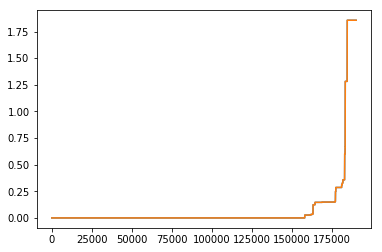

In [80]:
plt.plot(diff_sort1)
plt.plot(diff_sort2)

In [8]:
FOLDER_DATA = "/home/bapanes/Data/kaggle/Future_Sales/input/"

# Import all data inmediately  
sales=pd.read_csv(FOLDER_DATA + "sales_train_v2.csv")

# settings
import warnings
warnings.filterwarnings("ignore")

item_cat=pd.read_csv(FOLDER_DATA + "item_categories.csv")
item=pd.read_csv(FOLDER_DATA + "items.csv")
sub=pd.read_csv(FOLDER_DATA + "sample_submission.csv")
shops=pd.read_csv(FOLDER_DATA + "shops.csv")
test=pd.read_csv(FOLDER_DATA + "test.csv")

In [9]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [10]:
item.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [11]:
item_cat.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [12]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


# Formatting the date column propertly

In [13]:
sales.date=sales.date.apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y'))
# check
print(sales.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              datetime64[ns]
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB
None


In [14]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [15]:
sales.tail()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2935844,2015-10-10,33,25,7409,299.0,1.0
2935845,2015-10-09,33,25,7460,299.0,1.0
2935846,2015-10-14,33,25,7459,349.0,1.0
2935847,2015-10-22,33,25,7440,299.0,1.0
2935848,2015-10-03,33,25,7460,299.0,1.0


# Some numbers to take into account

In [16]:
amount_of_nodes_test = len(test)
amount_of_nodes_test

214200

In [17]:
total_number_of_sales = sales['item_cnt_day'].sum()
total_number_of_sales

3648206.0

In [18]:
total_number_of_sales/amount_of_nodes_test

17.031774042950513

So, we have around 10 sales for each node along 33 months. This is less than one sale for each month. With this satatistics seems difficult to have some level of prediction based on the information for each node only. Therefore we choose to group by some other variable, for instance the item_category_id

In [19]:
sales_extd = sales.join(item, on='item_id', rsuffix='_').join(item_cat, on='item_category_id', rsuffix='_').drop(['item_id_', 'item_category_id_', 'item_name', 'item_category_name'], axis=1)    
sales_extd_sort_by_item_category = sales_extd.sort_values('item_category_id')
sales_extd_sort_by_item_category.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
5558,2013-01-10,0,25,16257,148.0,1.0,0
439377,2013-04-02,3,38,16256,22.4,1.0,0
182616,2013-02-28,1,0,16255,93.0,1.0,0
112968,2013-01-10,0,45,5606,148.0,1.0,1
181531,2013-02-20,1,0,5740,283.0,1.0,1


In [20]:
number_of_cats_unique_in_sales = len(sales_extd_sort_by_item_category.item_category_id.value_counts())
number_of_cats_unique_in_sales

84

In [21]:
test_extd = test.join(item, on='item_id', rsuffix='_').join(item_cat, on='item_category_id', rsuffix='_').drop(['item_id_', 'item_category_id_', 'item_name', 'item_category_name'], axis=1)    
test_extd_sort_by_item_category = test_extd.sort_values('item_category_id')
test_extd_sort_by_item_category.head()

,ID,shop_id,item_id,item_category_id
156514,156514,55,5441,0
100414,100414,19,5441,0
49414,49414,31,5441,0
105514,105514,42,5441,0
13714,13714,6,5441,0


In [22]:
number_of_cats_unique_in_test = len(test_extd_sort_by_item_category.item_category_id.value_counts())
number_of_cats_unique_in_test

62

In [23]:
sales_per_category = total_number_of_sales/number_of_cats_unique_in_test/33
sales_per_category

1783.0918866080156

So, we see that in average we have 1000s sales per category per month. This indicates that at the category level we have much more statistics. However, we still have to check the distribution of measurements per category, in order to extend this average feeling

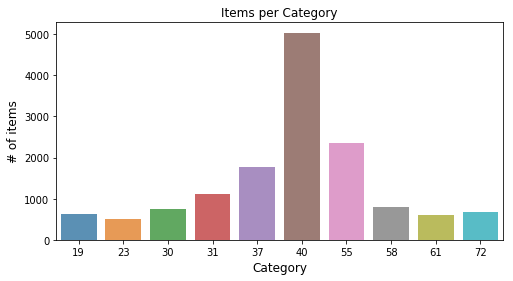

In [24]:
x=item.groupby(['item_category_id']).count()
x=x.sort_values(by='item_id',ascending=False)
x=x.iloc[0:10].reset_index()

#plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.item_category_id, x.item_id, alpha=0.8)
plt.title("Items per Category")
plt.ylabel('# of items', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.show()

We can see that there are categories with vastly different amount of items, which implies that the sales are going to be distributed in a similar way, as we will see in the print of item_category_id time series for item_cnt_day.sum

### So, we decide to predict the number of sales per item_category_id

This prediction can be done with different methods. In general, we should consider the time-series for each item category id in order to compute these predictions

In [25]:
sales_cat = sales.join(item, on = 'item_id', rsuffix='_').join(item_cat, on = 'item_category_id', rsuffix = "_").drop(['item_name','item_id_','item_category_id_'], axis =1)
sales_cat.tail()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,item_category_name
2935844,2015-10-10,33,25,7409,299.0,1.0,55,Музыка - CD локального производства
2935845,2015-10-09,33,25,7460,299.0,1.0,55,Музыка - CD локального производства
2935846,2015-10-14,33,25,7459,349.0,1.0,55,Музыка - CD локального производства
2935847,2015-10-22,33,25,7440,299.0,1.0,57,Музыка - MP3
2935848,2015-10-03,33,25,7460,299.0,1.0,55,Музыка - CD локального производства


In [26]:
# Let's pivot the above dataset to get a monthly time series:
sales_by_cat = sales_cat.pivot_table(index=['item_category_id'], values = ['item_cnt_day'], columns=['date_block_num'], 
                     aggfunc = np.sum, fill_value = 0 ).reset_index()
sales_by_cat.columns = sales_by_cat.columns.droplevel().map(str)
sales_by_cat = sales_by_cat.reset_index(drop=True).rename_axis(None, axis=1)
sales_by_cat.columns.values[0]= 'item_category_id'
sales_by_cat

,item_category_id,0,1,2,3,4,5,6,7,8,...,24,25,26,27,28,29,30,31,32,33
0,0,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,1390,1190,1025,646,596,667,618,674,792,...,370,307,229,170,146,104,114,132,89,82
3,3,440,302,293,202,146,150,233,300,383,...,1398,834,773,746,667,559,603,975,1090,1059
4,4,251,220,226,160,175,176,179,140,86,...,10,2,2,2,2,1,0,1,0,0
5,5,623,358,354,275,281,329,355,299,289,...,178,85,88,67,44,51,48,45,31,44
6,6,870,668,646,465,441,502,622,637,729,...,700,400,334,266,274,319,243,277,237,242
7,7,0,0,0,0,0,0,0,0,0,...,639,220,269,244,217,238,178,307,244,205
8,8,0,0,0,0,0,0,0,0,0,...,0,0,0,45,147,117,193,483,5128,-1
9,9,149,159,211,138,95,124,83,124,141,...,467,480,492,1003,2005,528,513,276,816,2524


In [27]:
months_array = np.array(['Jan', 'Feb','Mar','Apr','May','Jun','Jul','Ago','Sep','Oct','Nov','Dec','Jan', 'Feb','Mar','Apr','May','Jun','Jul','Ago','Sep','Oct','Nov','Dec','Jan', 'Feb','Mar','Apr','May','Jun','Jul','Ago','Sep','Oct','Nov','Dec'])
months_array

array(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Ago', 'Sep',
       'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
       'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar',
       'Apr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dec'],
      dtype='<U3')

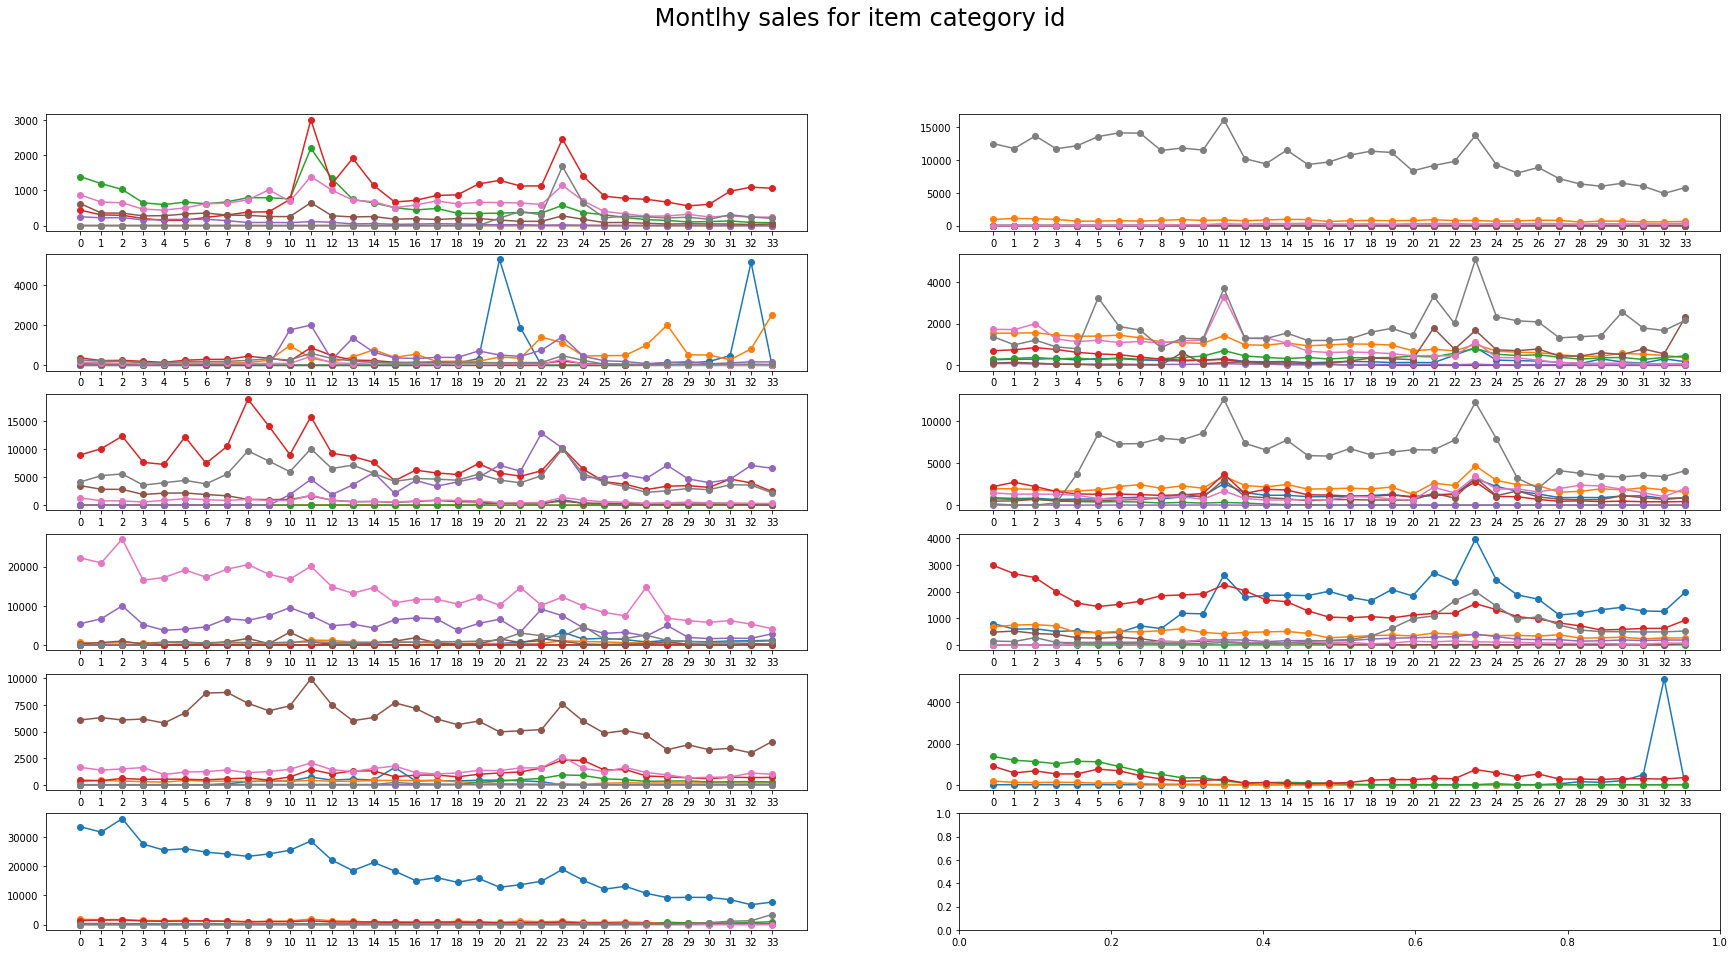

In [28]:
fig, ax = plt.subplots(6,2,figsize = (30,15))
ax[0][0].plot(sales_by_cat.columns[1:], sales_by_cat.iloc[:8,1:].T, 'o-')
ax[1][0].plot(sales_by_cat.columns[1:], sales_by_cat.iloc[8:16,1:].T, 'o-')
ax[2][0].plot(sales_by_cat.columns[1:], sales_by_cat.iloc[16:24,1:].T, 'o-')
ax[3][0].plot(sales_by_cat.columns[1:], sales_by_cat.iloc[24:32,1:].T, 'o-')
ax[4][0].plot(sales_by_cat.columns[1:], sales_by_cat.iloc[32:40,1:].T, 'o-')
ax[5][0].plot(sales_by_cat.columns[1:], sales_by_cat.iloc[40:48,1:].T, 'o-')
ax[0][1].plot(sales_by_cat.columns[1:], sales_by_cat.iloc[48:56,1:].T, 'o-')
ax[1][1].plot(sales_by_cat.columns[1:], sales_by_cat.iloc[56:64,1:].T, 'o-')
ax[2][1].plot(sales_by_cat.columns[1:], sales_by_cat.iloc[64:72,1:].T, 'o-')
ax[3][1].plot(sales_by_cat.columns[1:], sales_by_cat.iloc[72:80,1:].T, 'o-')
ax[4][1].plot(sales_by_cat.columns[1:], sales_by_cat.iloc[80:,1:].T, 'o-')

fig.suptitle(' Montlhy sales for item category id', fontsize = 24)  

plt.show()

In [29]:
months_array[34]

'Nov'

From the behavior of these categories we are going to start with a model that just considers that the prediction of the sales for the next month is equal to the sales of the previous one. Basically, we are assuming that during Novemmber (34th month is November) no big changes are seen in the plot of different categories. 

Anyway, it can be seen that for some categories November is the peak month for sales, thus we agree that this prediction can be improved later to better estimate the November prediction

# Routines to create the time series

In [30]:
months_array

array(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Ago', 'Sep',
       'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
       'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar',
       'Apr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dec'],
      dtype='<U3')

In [31]:
months_array[34]

'Nov'

In [32]:
months_array[22]

'Nov'

In [53]:
def measure_rmse(actual, predicted):
    
    rmse = np.average(abs(actual - predicted)**2/actual)
    
    #print(actual, predicted, math.sqrt(rmse))
    return math.sqrt(rmse)

def Exponential_Smoothing_Plus_Seasonal_Prediction(df, k, ntest):
    
    #From Holt-Winters to Exponential Smoothing plus Seasonal Parameters
    #current results using full time series category predictions show good performance
    
    # /https://stackoverflow.com/questions/50785479/holt-winters-time-series-forecasting-with-statsmodels
    
    #here k indicate the number of elements for the train, k=34
    #we add 10 to every element of the array to prevent over populatio of 0s from the original data
    #later we have to substract 10 to recover the true values for plots and final return
    
    series = df.iloc[:k, 0]+10 
    train, test = df.iloc[:-ntest, 0]+10, np.array(df.iloc[-ntest:, 0]+10)
   
    plt.plot(series.index, series-10, label='Original Series')
     
    pred = 10
    error = 0   
    #avoid time-series with null sales in the previous month
    
    
    if (series[k-1] > 10.0):
        
        df.index.freq = 'MS'
        
        model = ExponentialSmoothing(train, seasonal='mul', seasonal_periods=12).fit()

        
        #the start of the prediction is the array index to be predicted. the last month
        #of our input has index = 33 (k-1) therefore, the solution to our problem is the prediction at k=34
        #we predict two more months to see the tendency
        #if we predict from k-1 to k+1 we can join the previous ts at index=k-1=33 and still
        #the solution to our problem would be for k=34 (index magic, check please)
        
        pred_series_future = model.predict(start=k-ntest, end=k+1)    
        pred_series_before = model.predict(start=0, end=k-ntest-1)
        
        pred_series_for_error = np.array(pred_series_future[:-2])
       
        pred = pred_series_future[k]
        
        error = measure_rmse(test-10, pred_series_for_error-10)

        plt.plot(pred_series_future.index, pred_series_future-10, label='ESPS fit test + 2')
        plt.plot(pred_series_before.index, pred_series_before-10, label='ESPS fit train')
        plt.legend(loc='best')
        
    plt.show()  
    pred=pred-10
            
    return pred, error
    
def last_two_equal_months_average(it_cat_ts, month_pred):
    
    n_prev = month_pred - 12
    n_prev_prev = n_prev - 12
    
    average = (it_cat_ts.iloc[n_prev,0] + it_cat_ts.iloc[n_prev_prev,0])/2.0
    
    return average

def linear_regression_two_months(it_cat_ts, month_pred):
    
    dx = 12
    
    x3 = month_pred
    x2 = x3 - dx
    x1 = x2 - dx
    
    y2 = it_cat_ts.iloc[x2,0]
    y1 = it_cat_ts.iloc[x1,0]
      
    y3 = (x3-x2)*(y2-y1)/dx + y2
    
    return y3


def shop_probability(test_extd_shop_id, test_extd_item_id, test_extd_cate_id, sales_join_cat, test_extd):
    
    shop = test_extd_shop_id
    item = test_extd_item_id
    cate = test_extd_cate_id
       
    #extended sales df, including item_category_id
    #sales_join_cat = sales.join(item, on='item_id', rsuffix='_').join(item_cat, on='item_category_id', rsuffix='_').drop(['item_id_', 'item_category_id_'], axis=1)

    #reducing sales_join_cat by filtering only by category 
    sales_category = sales_join_cat[(sales_join_cat.item_category_id == cate)]
    
    #reducing sales_join_cat by filtering category and shop 
    sales_shop_category = sales_join_cat[(sales_join_cat.item_category_id == cate) & (sales_join_cat.shop_id == shop)]
    
    #reducing sales_join_cat by filtering by item and shop 
    sales_shop_item = sales_join_cat[(sales_join_cat.item_id == item) & (sales_join_cat.shop_id == shop)]
    
    #############################################
        
    #adding all the sales for the category
    total_sales_category = sales_category['item_cnt_day'].sum()
    
    #adding all the sales for the category (along all the products and shops that contribute)
    total_sales_shop_category = sales_shop_category['item_cnt_day'].sum()
    
    #adding all the sales for each node
    total_sales_shop_item = sales_shop_item['item_cnt_day'].sum()
    
    #required products
    req_prods = len(test_extd[(test_extd.item_category_id == cate) & (test_extd.shop_id == shop)])
    
    p_shop = 0
    p_shop_item = 0
    
    if ((total_sales_shop_category != 0) & (total_sales_category != 0)):
    
        p_shop = total_sales_shop_category/total_sales_category
        p_shop_item = p_shop/req_prods
    
    return total_sales_shop_category, total_sales_category, p_shop, req_prods, p_shop_item


def sales_time_series_catId(test_ext_item_cate_id,sales_join_cat): 
    
    prod_cat = test_ext_item_cate_id
    
    #extended sales df, including item_category_id
    #sales_join_cat = sales.join(item, on='item_id', rsuffix='_').join(item_cat, on='item_category_id', rsuffix='_').drop(['item_id_', 'item_category_id_'], axis=1)

    #reduced df filtering by product_category 
    sales_prod_cat = sales_join_cat[(sales_join_cat.item_category_id == prod_cat)]

    #for monthly summary sales we consider the total month sales of each category
    monthly_sales = sales_prod_cat.groupby(["date_block_num"])["item_cnt_day"].sum()
    
    #reset of months lables
    dates = pd.date_range(start = '2013-01-01',end='2015-10-01', freq = 'MS')
    
    time_series_cat = pd.DataFrame({"node_tot_cnt":[0]*dates.shape[0]},columns=["node_tot_cnt"])
    
    if (sales_prod_cat.shape[0] > 0):
        for con in range(monthly_sales.shape[0]): 
            index_date_block = monthly_sales.index[con]
            count_date_block = monthly_sales.iloc[con]
   
            # here we fill the histories, always leaving the zero position to the featiure 
            # to be predicted [0]!!!!
            time_series_cat.iloc[index_date_block,0] = count_date_block

    return time_series_cat
    
def sales_time_series_shopId_catId(store_id, prod_id):
    
    #product category associated to the prod_id
    prod_cat = item[item.item_id == prod_id]['item_category_id'].get_values()[0]
    
    #extended sales df, including item_category_id
    sales_join_cat = sales.join(item, on='item_id', rsuffix='_').join(item_cat, on='item_category_id', rsuffix='_').drop(['item_id_', 'item_category_id_'], axis=1)
    
    #reduced df filtering by product_category and shop_id. Still, we have several products involved for each day
    sales_prod_store = sales_join_cat[(sales_join_cat.item_category_id == prod_cat) & (sales_join_cat.shop_id == store_id)]
    
    #for the sale of each day we consider the mean over different products
    #we use agg instead of sum() because it generates a dataframe wchich is very readable
    sales_prod_store_sum_day = sales_prod_store.groupby(['date','date_block_num'], as_index=False).agg({'item_cnt_day': 'sum'})
    
    #for monthly summary sales we consider the total sum of days
    monthly_sales = sales_prod_store_sum_day.groupby(["date_block_num"])["item_cnt_day"].sum()
    
    #we normalize the montly sale of the given product by the probability to sale that product in the shop 
    #we compute that probability as given by the total_sales_product/total_sales_category
    
    prob_product = 0  
        
    #total sales of each item for this particular shop 
    item_sales_all = sales_prod_store.groupby(['item_id'], as_index=False).agg({'item_cnt_day':'sum'})
    
    #first, we check if this item has been sold at all
    if len(item_sales_all[item_sales_all.item_id == prod_id] > 0):
        total_item_sales = item_sales_all['item_cnt_day'].sum()
        indiv_item_sales = item_sales_all[item_sales_all.item_id == prod_id]['item_cnt_day'].get_values()[0]
        
        prob_product = indiv_item_sales/total_item_sales
        
    #monthly_sales = monthly_sales*prob_product
    
    #reset of months lables
    dates = pd.date_range(start = '2013-01-01',end='2015-10-01', freq = 'MS')
    
    nullhistory = pd.DataFrame({"node_tot_cnt":[0]*dates.shape[0]},columns=["node_tot_cnt"])
    
    if (sales_prod_store.shape[0] > 0):
        for con in range(monthly_sales.shape[0]): 
            index_date_block = monthly_sales.index[con]
            count_date_block = monthly_sales.iloc[con]
   
            # here we fill the histories, always leaving the zero position to the featiure 
            # to be predicted [0]!!!!
            nullhistory.iloc[index_date_block,0] = count_date_block
     
    return prob_product, nullhistory

def sales_summary_dataframe(shop_id_history, item_id_history):
   
    sales_shop_item = sales[(sales.shop_id==shop_id_history) & (sales.item_id == item_id_history)]
    
    monthly_sales_shop_item = sales_shop_item.groupby(["date_block_num"])["item_cnt_day"].sum()
    
    dates = pd.date_range(start = '2013-01-01',end='2015-10-01', freq = 'MS')
    
    nullhistory = pd.DataFrame({"node_tot_cnt":[0]*dates.shape[0]},columns=["node_tot_cnt"])
    
    if (sales_shop_item.shape[0] > 0):
        for con in range(monthly_sales_shop_item.shape[0]): 
            index_date_block = monthly_sales_shop_item.index[con]
            count_date_block = monthly_sales_shop_item.iloc[con]
   
            # here we fill the histories, always leaving the zero position to the featiure 
            # to be predicted [0]!!!!
            nullhistory.iloc[index_date_block,0] = count_date_block
    
    return nullhistory    

In [35]:
class Timer():

    def __init__(self):
        self.start_dt = None

    def start(self):
        self.start_dt = dt.datetime.now()

    def stop(self):
        end_dt = dt.datetime.now()
        print('Time taken: %s' % (end_dt - self.start_dt))

In [54]:
test_extd_sort_by_item_category.tail()

,ID,shop_id,item_id,item_category_id
31189,31189,10,22091,83
117888,117888,53,22088,83
117889,117889,53,22091,83
41389,41389,28,22091,83
153589,153589,55,22091,83


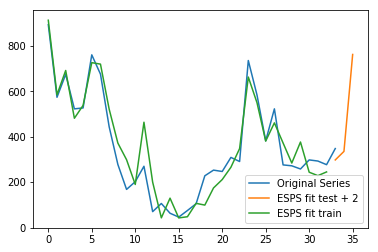

In [55]:
df = sales_time_series_catId(83, sales_cat) 
Prediction, Error = Exponential_Smoothing_Plus_Seasonal_Prediction(df,34,1)

# Run over all the nodes

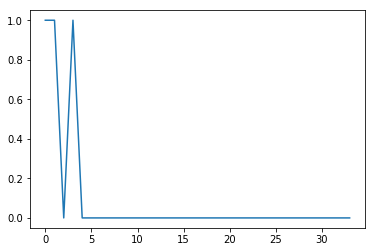

Cell_33 (Naive), Error_33, Holt_34, Final:  0.0 0 0 0


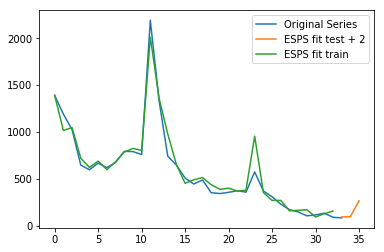

Cell_33 (Naive), Error_33, Holt_34, Final:  82.0 1.2067109474846645 94.55741618559105 82.0


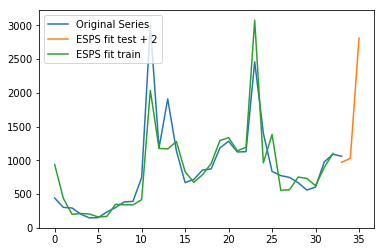

Cell_33 (Naive), Error_33, Holt_34, Final:  1059.0 2.757706598027938 1029.4496112943712 1059.0


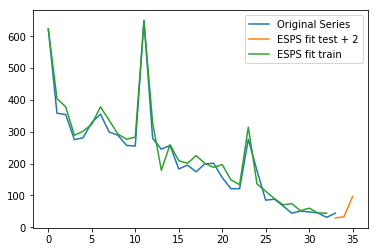

Cell_33 (Naive), Error_33, Holt_34, Final:  44.0 2.2194661632159924 33.05153661611223 44.0


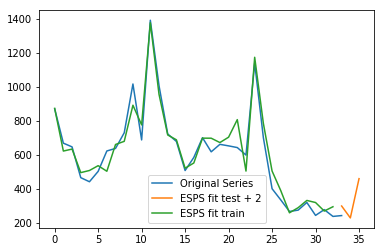

Cell_33 (Naive), Error_33, Holt_34, Final:  242.0 3.613086115047891 228.18364369867274 242.0


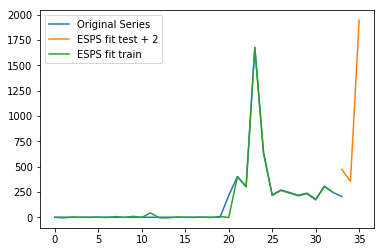

Cell_33 (Naive), Error_33, Holt_34, Final:  205.0 18.7547637028337 354.00533803856115 205.0


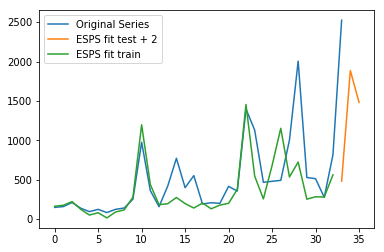

Cell_33 (Naive), Error_33, Holt_34, Final:  2524.0 40.65130623543501 1885.2637550455752 2524.0


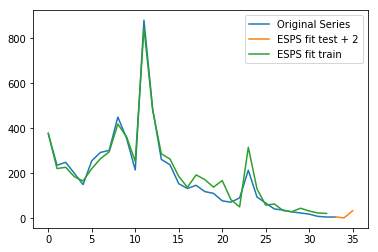

Cell_33 (Naive), Error_33, Holt_34, Final:  6.0 0.3703883268944775 2.1068584276515114 2.1068584276515114


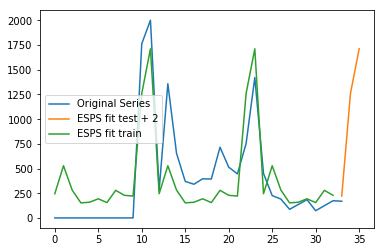

Cell_33 (Naive), Error_33, Holt_34, Final:  169.0 4.021368554635164 1260.361376199799 169.0


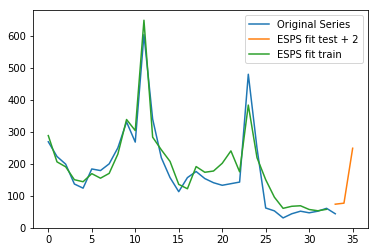

Cell_33 (Naive), Error_33, Holt_34, Final:  43.0 4.558216674776284 76.10205946184313 43.0


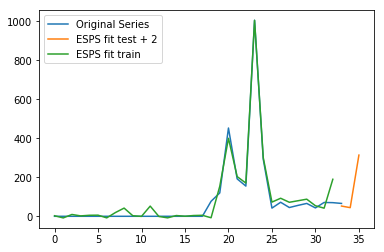

Cell_33 (Naive), Error_33, Holt_34, Final:  66.0 1.6602932279468958 44.39009767493924 66.0


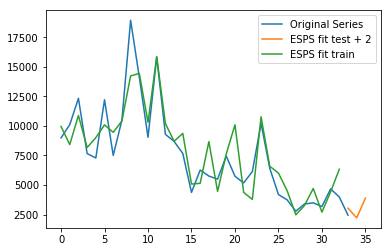

Cell_33 (Naive), Error_33, Holt_34, Final:  2443.0 11.922615163340417 2211.9845144884043 2443.0


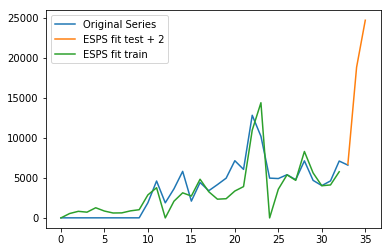

Cell_33 (Naive), Error_33, Holt_34, Final:  6596.0 1.467307767575066 18837.711957941752 6596.0


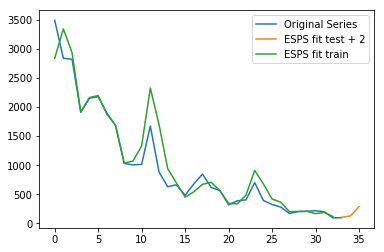

Cell_33 (Naive), Error_33, Holt_34, Final:  98.0 0.6731215448746783 128.63060718004832 128.63060718004832


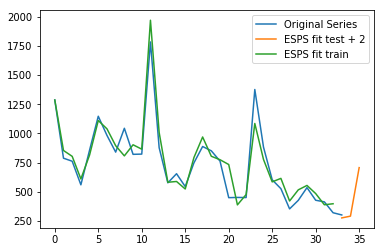

Cell_33 (Naive), Error_33, Holt_34, Final:  302.0 1.4581743229087556 291.8850533710382 302.0


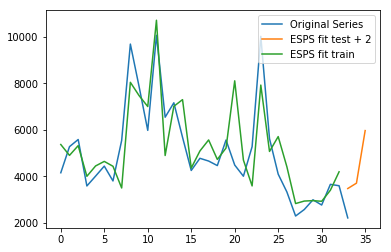

Cell_33 (Naive), Error_33, Holt_34, Final:  2203.0 26.98721771754306 3701.576072381397 2203.0


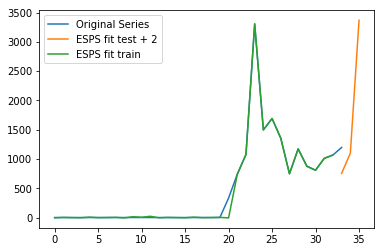

Cell_33 (Naive), Error_33, Holt_34, Final:  1197.0 12.775284987137296 1098.6525111931828 1197.0


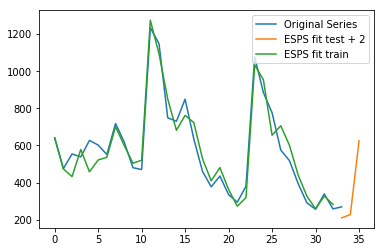

Cell_33 (Naive), Error_33, Holt_34, Final:  269.0 3.634328079398424 227.27474314066424 269.0


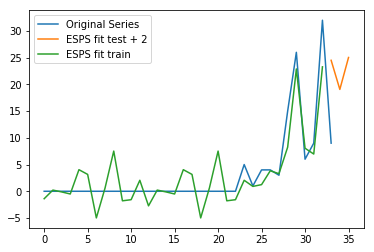

Cell_33 (Naive), Error_33, Holt_34, Final:  9.0 5.167997591443357 19.05877775560066 9.0


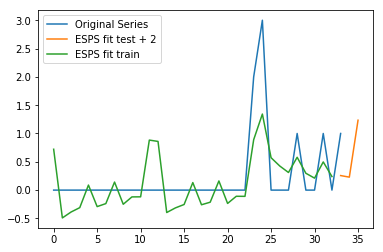

Cell_33 (Naive), Error_33, Holt_34, Final:  1.0 0.7432621102057109 0.22891969287613279 0.22891969287613279


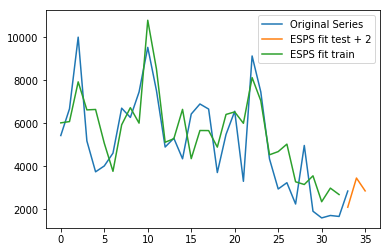

Cell_33 (Naive), Error_33, Holt_34, Final:  2857.0 14.042497887019403 3460.542761800043 2857.0


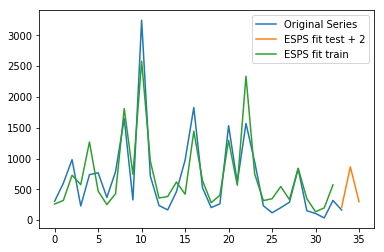

Cell_33 (Naive), Error_33, Holt_34, Final:  165.0 3.433445473954011 865.0238814456727 165.0


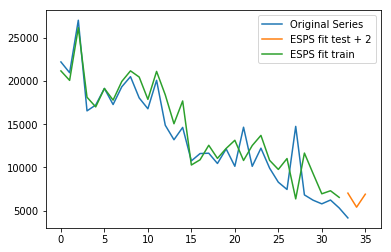

Cell_33 (Naive), Error_33, Holt_34, Final:  4150.0 44.569770340306306 5394.547388349113 4150.0


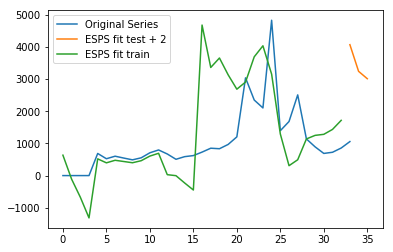

Cell_33 (Naive), Error_33, Holt_34, Final:  1056.0 92.60289523625559 3237.382327035376 1056.0


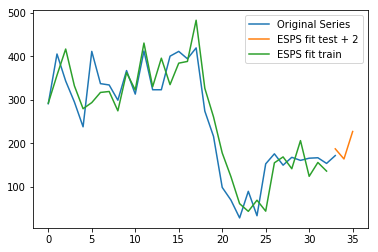

Cell_33 (Naive), Error_33, Holt_34, Final:  172.0 1.179084799540143 164.2087449352152 172.0


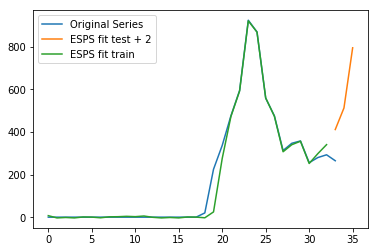

Cell_33 (Naive), Error_33, Holt_34, Final:  265.0 9.007220878186816 512.9161169671847 265.0


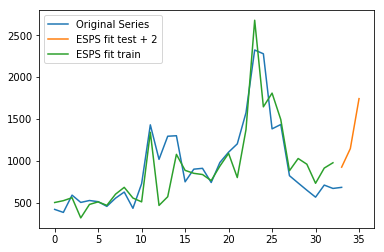

Cell_33 (Naive), Error_33, Holt_34, Final:  685.0 9.202997583039103 1147.546037702413 685.0


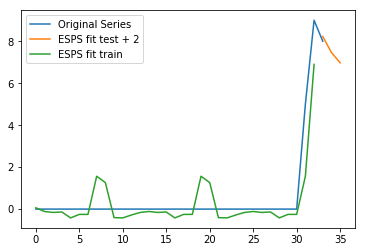

Cell_33 (Naive), Error_33, Holt_34, Final:  8.0 0.07992914370109815 7.4611889090719075 7.4611889090719075


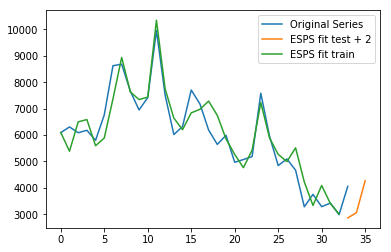

Cell_33 (Naive), Error_33, Holt_34, Final:  4061.0 18.755589828468395 3065.8578464182065 4061.0


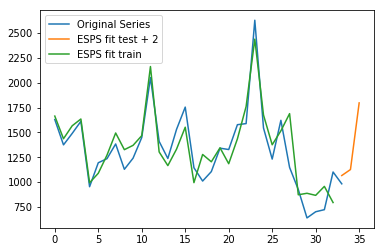

Cell_33 (Naive), Error_33, Holt_34, Final:  983.0 2.6622901875236398 1126.7017227482352 983.0


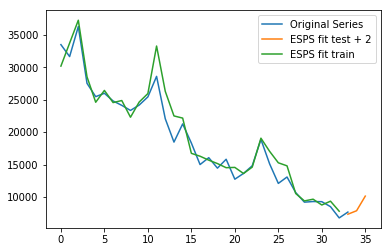

Cell_33 (Naive), Error_33, Holt_34, Final:  7680.0 3.7652211865450904 7885.008834351848 7680.0


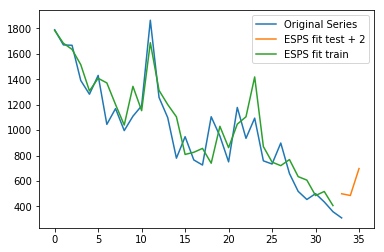

Cell_33 (Naive), Error_33, Holt_34, Final:  309.0 10.816051530650888 485.3553827154796 309.0


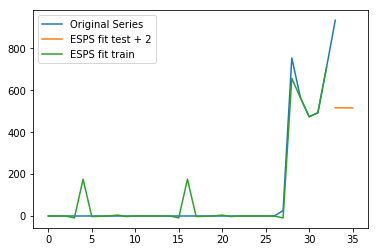

Cell_33 (Naive), Error_33, Holt_34, Final:  934.0 13.665663764505188 516.0284181450999 934.0


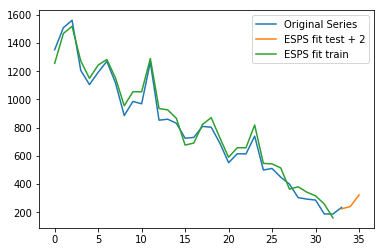

Cell_33 (Naive), Error_33, Holt_34, Final:  235.0 0.6392576346585733 241.26835753201996 241.26835753201996


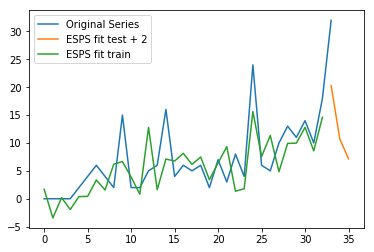

Cell_33 (Naive), Error_33, Holt_34, Final:  32.0 2.0718705781692544 10.712802153097076 32.0


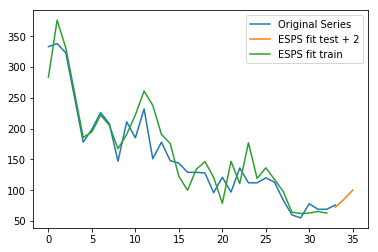

Cell_33 (Naive), Error_33, Holt_34, Final:  76.0 0.40507268594548185 85.41292600551992 85.41292600551992


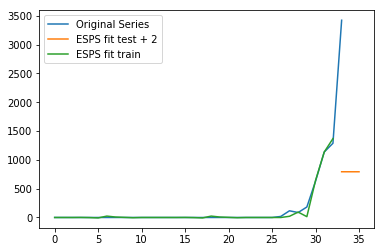

Cell_33 (Naive), Error_33, Holt_34, Final:  3421.0 44.92883515429501 792.8905573713708 3421.0


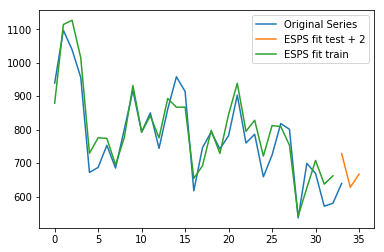

Cell_33 (Naive), Error_33, Holt_34, Final:  639.0 3.5430289789257565 627.5203151380059 639.0


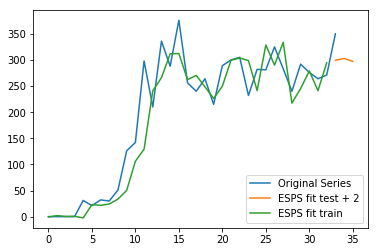

Cell_33 (Naive), Error_33, Holt_34, Final:  350.0 2.7151637900890653 302.8987107810718 350.0


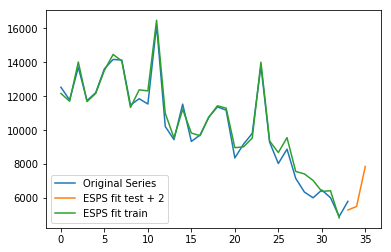

Cell_33 (Naive), Error_33, Holt_34, Final:  5808.0 6.708191643518107 5504.155386900209 5808.0


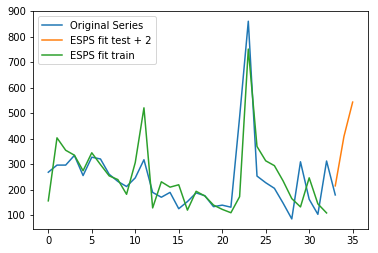

Cell_33 (Naive), Error_33, Holt_34, Final:  179.0 2.65534768734925 408.4593270274895 179.0


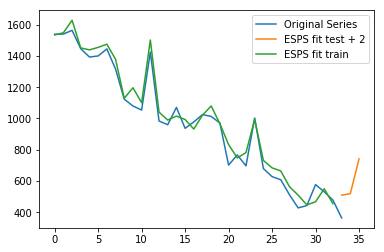

Cell_33 (Naive), Error_33, Holt_34, Final:  364.0 7.614885072904737 519.1824291253508 364.0


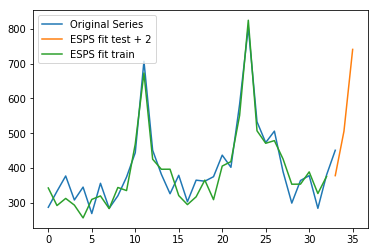

Cell_33 (Naive), Error_33, Holt_34, Final:  451.0 3.4373662909574088 505.8558772620804 451.0


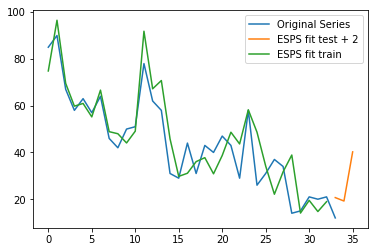

Cell_33 (Naive), Error_33, Holt_34, Final:  12.0 2.508349535196533 19.22468051397436 12.0


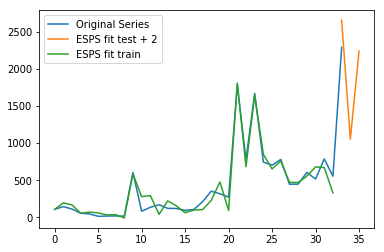

Cell_33 (Naive), Error_33, Holt_34, Final:  2290.0 7.613329251941775 1053.6238657787533 2290.0


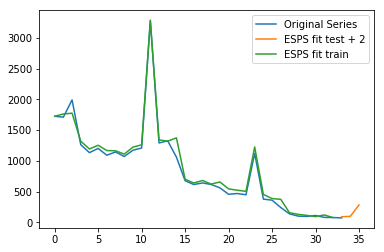

Cell_33 (Naive), Error_33, Holt_34, Final:  73.0 2.1671511557488867 99.12046550588268 73.0


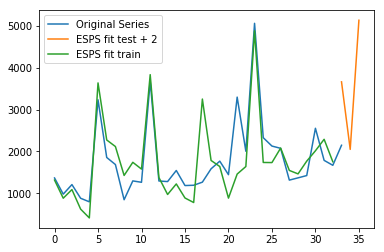

Cell_33 (Naive), Error_33, Holt_34, Final:  2149.0 32.70533080425024 2050.6823485986947 2149.0


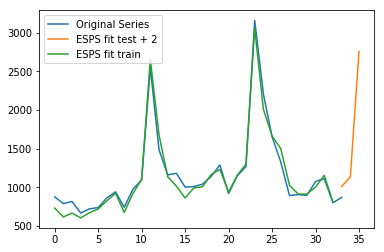

Cell_33 (Naive), Error_33, Holt_34, Final:  870.0 4.76356578646849 1135.108573399396 870.0


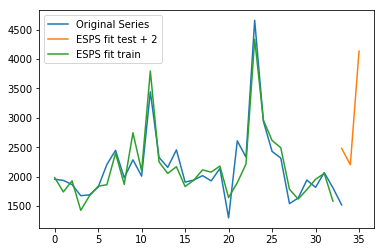

Cell_33 (Naive), Error_33, Holt_34, Final:  1518.0 24.68397364098706 2202.8730263441084 1518.0


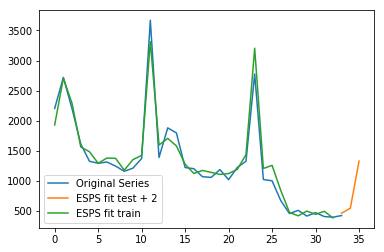

Cell_33 (Naive), Error_33, Holt_34, Final:  426.0 1.9082149051105457 547.8000061016287 426.0


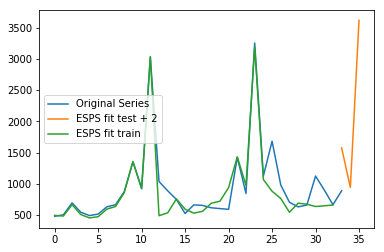

Cell_33 (Naive), Error_33, Holt_34, Final:  888.0 23.071306040918277 941.9760098673802 888.0


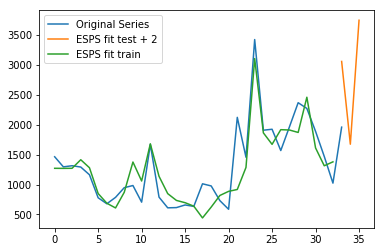

Cell_33 (Naive), Error_33, Holt_34, Final:  1960.0 24.823783573227068 1674.9530354710994 1960.0


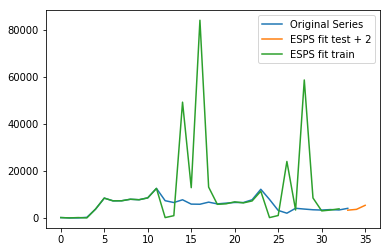

Cell_33 (Naive), Error_33, Holt_34, Final:  4078.0 12.159131343369092 3643.0232530292587 4078.0


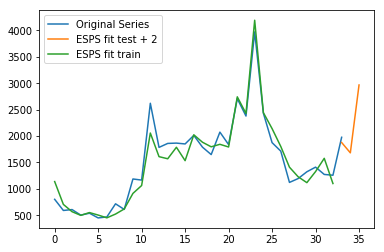

Cell_33 (Naive), Error_33, Holt_34, Final:  1976.0 2.2219859802349724 1681.942356726428 1976.0


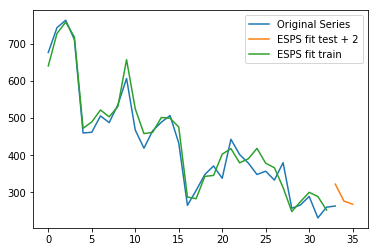

Cell_33 (Naive), Error_33, Holt_34, Final:  263.0 3.643976649755266 276.34803023653365 263.0


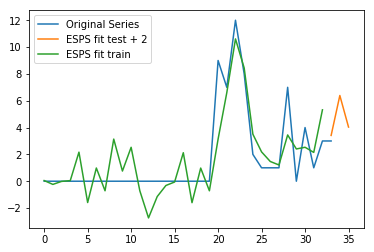

Cell_33 (Naive), Error_33, Holt_34, Final:  3.0 0.23912556727518097 6.390795894101316 6.390795894101316


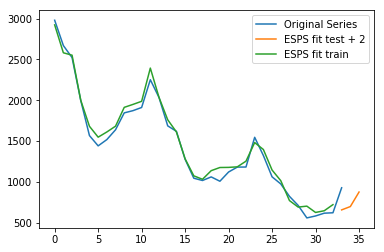

Cell_33 (Naive), Error_33, Holt_34, Final:  929.0 8.88199778383636 698.9546908256096 929.0


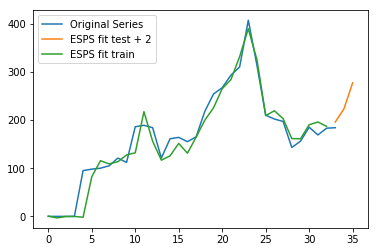

Cell_33 (Naive), Error_33, Holt_34, Final:  184.0 0.8746320982659845 223.33533008443905 223.33533008443905


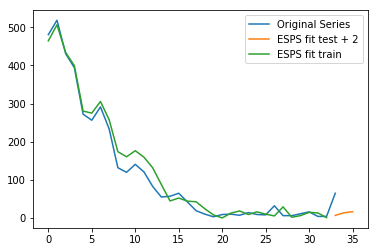

Cell_33 (Naive), Error_33, Holt_34, Final:  64.0 7.292320901750616 12.559724905307565 64.0


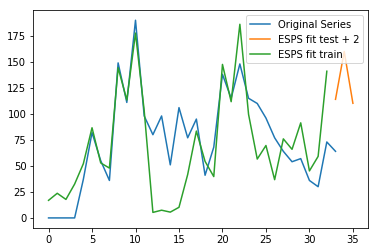

Cell_33 (Naive), Error_33, Holt_34, Final:  64.0 6.246485787924277 159.95526465672674 64.0


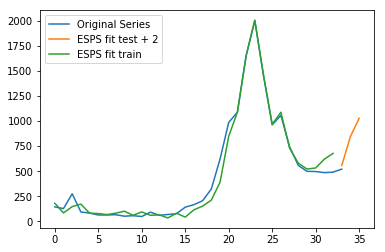

Cell_33 (Naive), Error_33, Holt_34, Final:  521.0 1.5841729266555373 846.0372744802523 521.0


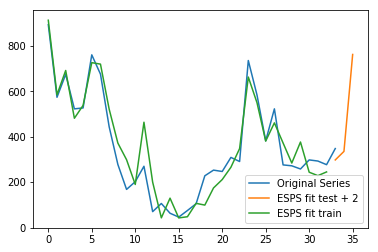

Cell_33 (Naive), Error_33, Holt_34, Final:  348.0 2.68938425391348 335.4820497353279 348.0


In [63]:
start_time=time.time()

list_of_nodes =[]
list_of_node_predictions = []
list_of_cat_predictions = []
list_of_shop_prob = []
list_of_req_prods = []

status_file = open('status_file_pred_by_cat.txt','w+')
status_file.write("Dont be patient\n")
status_file.close()

#starting the values of it cat id and prediction
test_extd_cate_id_aux = -1
next_month_prediction_value_item_cat = 0.5

prob_node = 0
prob_total_cat = 0

#extension of sales df to group by id_cat, etc
#extension of test df to group by id_cat, etc

sales_join_cat = sales.join(item, on='item_id', rsuffix='_').join(item_cat, on='item_category_id', rsuffix='_').drop(['item_id_', 'item_category_id_'], axis=1)
test_join_cat = test.join(item, on='item_id', rsuffix='_').join(item_cat, on='item_category_id', rsuffix='_').drop(['item_id_', 'item_category_id_', 'item_name', 'item_category_name'], axis=1)    

test_join_cat_sort_by_item_category = test_join_cat.sort_values('item_category_id')

for node in tqdm_notebook(range(len(test_join_cat_sort_by_item_category))):
#for node in tqdm_notebook(range(100)):    
    
    #reading the item_category_id
    test_extd_node_id = test_extd_sort_by_item_category.iloc[node,0]
    test_extd_shop_id = test_extd_sort_by_item_category.iloc[node,1]
    test_extd_item_id = test_extd_sort_by_item_category.iloc[node,2] 
    test_extd_cate_id = test_extd_sort_by_item_category.iloc[node,3]  
      
    #decision about training to modify the prediction fo the next month 
    
    if (test_extd_cate_id != test_extd_cate_id_aux):    
                           
        #block the next node if cat is the same as current
        test_extd_cate_id_aux = test_extd_cate_id
             
        #reading the time-series for this category
        it_cat_ts = sales_time_series_catId(test_extd_cate_id,sales_join_cat)   
                     
        #previous month prediction    
        pred_naive = it_cat_ts['node_tot_cnt'][it_cat_ts.values.shape[0]-1]
        
        #last two november averages model
        #next_month_prediction_cat = last_two_equal_months_average(it_cat_ts,34)
        #next_month_prediction_cat = linear_regression_two_months(it_cat_ts, 34)
               
        next_month_prediction_cat = pred_naive
        pred_holt = pred_naive
        error = 0        
        
        pred_holt, error = Exponential_Smoothing_Plus_Seasonal_Prediction(it_cat_ts,34,1)
                
        #sigma = abs((pred_naive - pred_33)/math.sqrt(pred_naive))
       
        if (error < 1):
            next_month_prediction_cat = pred_holt
        
        print('Cell_33 (Naive), Error_33, Holt_34, Final: ', pred_naive, error, pred_holt, next_month_prediction_cat)
        
        #printing time series and prediction      
        
        #fig, ax = plt.subplots(1, figsize=(10, 5))
        #ax.plot(it_cat_ts)
        #fig.suptitle(str(next_month_prediction_cat) + ' Montlhy sales for item category id ' + str(test_extd_cate_id_aux), fontsize = 14)  
        #plt.show()
        
        ############
      
    total_sales_shop_category, total_sales_category, shop_prob, req_prods, shop_item_prob = shop_probability(test_extd_shop_id, test_extd_item_id, test_extd_cate_id, sales_join_cat, test_join_cat)
    
    #print(test_extd_shop_id, test_extd_item_id, test_extd_cate_id, total_sales_shop_category, total_sales_category,
    #      shop_item_prob, req_prods)
                
    #computation of the node probability in the sub-sapace of nodes that belong to the same item category
        
    node_lstm_prediction = next_month_prediction_cat*shop_item_prob
    
    #end of prediction
    
    #saving values for chi2
        
    if (node_lstm_prediction > 20):
        node_lstm_prediction = 20
        
    if (node_lstm_prediction < 0):
        node_lstm_prediction = 0
       
    list_of_nodes.append(test_extd_node_id)   
    list_of_node_predictions.append(node_lstm_prediction)
    list_of_cat_predictions.append(next_month_prediction_cat)
    list_of_shop_prob.append(shop_prob)
    list_of_req_prods.append(req_prods)

    if (((node % 10 == 0) and (node < 100)) or (node % 1000 == 0)):
        end_time=time.time()
        
        #status_output = "forecasting for "+ str(node) +"th node and took" + str(end_time-start_time) + "s"

        status_file = open('status_file_pred_by_cat_VII.txt','a')
        
        status_file.write("Node "+ str(node) +" took " + str(end_time-start_time) + " s with ") 
        status_file.write("Prediction: "+ str(next_month_prediction_cat) + " x " + str(shop_item_prob) + " = "+  str(node_lstm_prediction) + "\n")

        status_file.close()

        #print()
        start_time=end_time

              
#check df       
dfchecks = pd.DataFrame({"ID":list_of_nodes,"shop_item_cnt_month":list_of_node_predictions,
                         "category_cnt_month":list_of_cat_predictions,
                         "shop_prob":list_of_shop_prob,
                         "req_prods":list_of_req_prods, }, 
                          columns=["ID","shop_item_cnt_month","category_cnt_month","shop_prob","req_prods"]) 

#submission file   
dfsubmission = pd.DataFrame({"ID":list_of_nodes,"item_cnt_month":list_of_node_predictions},
                            columns=["ID","item_cnt_month"])

dfsubmission =dfsubmission.sort_values('ID')

dfsubmission.to_csv('submission_file_by_CategoryId_times_Prob_VII.csv',index=False)

# Checks

In [102]:
dfchecks1 = dfchecks.join(test, on='ID', rsuffix='_').drop(['ID_'],axis=1)
dfchecks2 = dfchecks1.join(item, on='item_id',rsuffix='_').drop(['item_name','item_id_'],axis=1)
dfchecks2.head()

,ID,shop_item_cnt_month,category_cnt_month,shop_prob,req_prods,shop_id,item_id,item_category_id
0,156514,0.0,0.0,0.0,1,55,5441,0
1,100414,0.0,0.0,0.0,1,19,5441,0
2,49414,0.0,0.0,0.0,1,31,5441,0
3,105514,0.0,0.0,0.0,1,42,5441,0
4,13714,0.0,0.0,0.0,1,6,5441,0


In [103]:
dfchecks2[(dfchecks2.item_category_id == 3) & (dfchecks2.shop_id == 18)].head()

,ID,shop_item_cnt_month,category_cnt_month,shop_prob,req_prods,shop_id,item_id,item_category_id


In [104]:
dfchecks2 = dfchecks2[['ID','shop_id','item_id','item_category_id','category_cnt_month','shop_prob','req_prods','shop_item_cnt_month']]
dfchecks3 = dfchecks2.sort_values('ID').reset_index(drop=True)
dfchecks3.head()

,ID,shop_id,item_id,item_category_id,category_cnt_month,shop_prob,req_prods,shop_item_cnt_month
0,1515,5,13536,2,82.0,0.011839,10,0.097076
1,3514,5,5441,0,0.0,0.000000,1,0.000000
2,4264,5,13535,2,82.0,0.011839,10,0.097076
3,8614,4,5441,0,0.0,0.000000,1,0.000000
4,9364,4,13535,2,82.0,0.015768,10,0.129295


In [106]:
len(dfchecks2[(dfchecks2.item_category_id == 0) & (dfchecks2.shop_id == 5)])

1

In [99]:
82*0.011839/10

0.09707980000000001

In [109]:
len(sales_cat[(sales_cat.item_category_id == 0) & (sales_cat.shop_id == 4)])

0